In [30]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.networks import SuperMultiDiGraph
from krxns.cheminfo import draw_reaction
from IPython.display import SVG
import json
from scipy.stats import spearmanr
from itertools import chain
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Load unpaired cofactors
with open(filepaths['cofactors'] / 'expanded_unpaired_cofactors.json', 'r') as f:
    unpaired_cofactors = json.load(f)

# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Load coreactant whitelist
with open(filepaths['cofactors'] / 'pickaxe_whitelist.json', 'r') as f:
    coreactant_whitelist = json.load(f)

# Get known compounds
kcs, smi2id = extract_compounds(krs)

tani_sim_mat = np.load(filepaths['sim_mats'] / "tanimoto.npy")

In [32]:
atom_lb = 0.0
cw = coreactant_whitelist

G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(
    operator_connections=op_cxns,
    similarity_connections=sim_cxn,
    side_counts=side_counts,
    reactions=krs,
    unpaired_cofactors=unpaired_cofactors,
    connect_nontrivial=False,
    atom_lb=atom_lb,
    coreactant_whitelist=cw
)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [33]:
paths = nx.shortest_path(G)

# Filter out self-paths
tmp = {}
for i in paths:
    destinations = {j: elt for j, elt in paths[i].items() if i != j}
    if destinations:
        tmp[i] = destinations
paths = tmp

<class 'networkx.utils.decorators.argmap'> compilation 4:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


In [35]:
tmp = {}
for i in paths:
    for j in paths[i]:
        tmp[(i, j)] = paths[i][j]

In [37]:
path_tanis = defaultdict(dict)
path_tanis_all_successors = defaultdict(dict)
n_paths = 0
ds = 100
for i in list(paths.keys())[::ds]:
    for j in paths[i]:
        col_idxs = paths[i][j]
        path_tanis[i][j] = tani_sim_mat[j, col_idxs]

        if len(col_idxs) > 2:
            succ_scores = [tani_sim_mat[j, list(G.successors(c))] for c in col_idxs[:-2]]
            path_tanis_all_successors[i][j] = succ_scores
        
        n_paths += 1
print(f"# paths = {n_paths}")

# paths = 43958


In [38]:
ds = 1
path_spearmans = {}
for i in list(path_tanis.keys())[::ds]:
    path_spearmans[i] = {}
    for j in path_tanis[i]:
        tanis = path_tanis[i][j]
        path_spearmans[i][j] = spearmanr(np.arange(len(tanis)), tanis).statistic

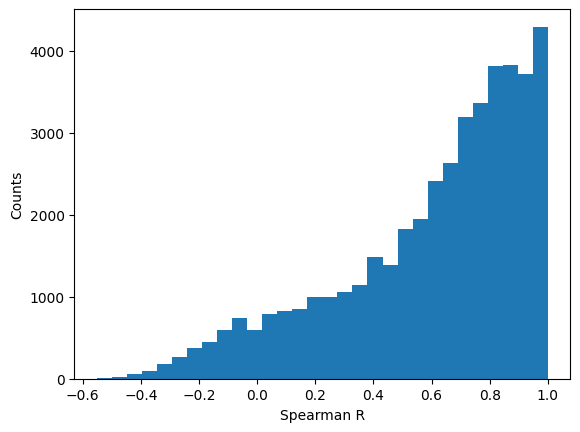

In [39]:
spearman_rs = list(chain(*[elt.values() for elt in path_spearmans.values()]))
fig, ax = plt.subplots()
ax.hist(spearman_rs, bins=30)
ax.set_ylabel("Counts")
ax.set_xlabel("Spearman R")
plt.show()

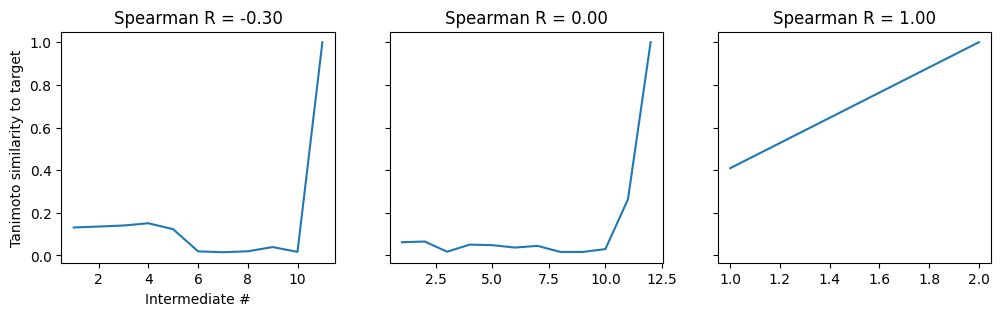

In [58]:
negative_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] + 0.3) < 1e-4:
            negative_spearman_traces[(i, j)] = path_tanis[i][j]

zero_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j]) < 1e-4:
            zero_spearman_traces[(i, j)] = path_tanis[i][j]

one_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] - 1) < 1e-4:
            one_spearman_traces[(i, j)] = path_tanis[i][j]

fig, ax = plt.subplots(ncols=3, figsize=(12, 3), sharey=True)

traces = [negative_spearman_traces, zero_spearman_traces, one_spearman_traces]

idx = 2
sts = [list(elt.keys())[min(idx, len(elt) - 1)] for elt in traces]

plot_it = lambda i, st : ax[i].plot(np.arange(1, len(traces[i][st]) + 1), traces[i][st])

for i, st in enumerate(sts):
    plot_it(i, st)
    s, t = st
    ax[i].set_title(f"Spearman R = {path_spearmans[s][t]:.2f}")

ax[0].set_ylabel(f"Tanimoto similarity to target")
ax[0].set_xlabel("Intermediate #")
plt.show()

OVERALL:  all-trans-4-hydroxyretinoate >> (-)-beta-barbatene


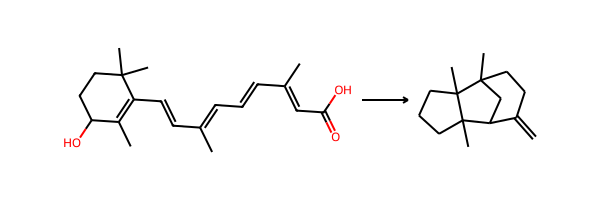

STEP #1
[('rid', 4198), ('rhea_ids', [51985, 51493, 75848]), ('imt_rules', None), ('weight', 1), ('requires', {'Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)COP(=O)(O)O)c2cc1C': 1, 'O': 1}), ('other_products', {'Cc1cc2c(cc1C)N(CC(O)C(O)C(O)COP(=O)(O)O)c1[nH]c(=O)[nH]c(=O)c1N2': 1, 'O=O': 1})]


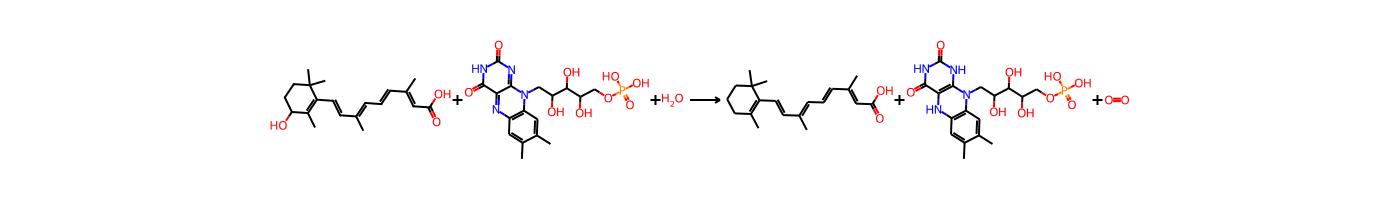

STEP #2
[('rid', 9078), ('rhea_ids', [56738, 22522]), ('imt_rules', ['rule0147_2']), ('weight', 1.0), ('requires', {'OO': 1}), ('other_products', {'O': 1, 'O=O': 1})]


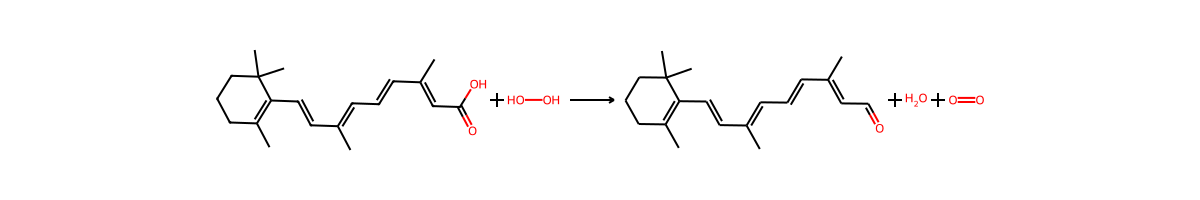

STEP #3
[('rid', 6332), ('rhea_ids', [32888]), ('imt_rules', ['rule0118_2']), ('weight', 0.5), ('requires', {}), ('other_products', {'O=O': 1})]


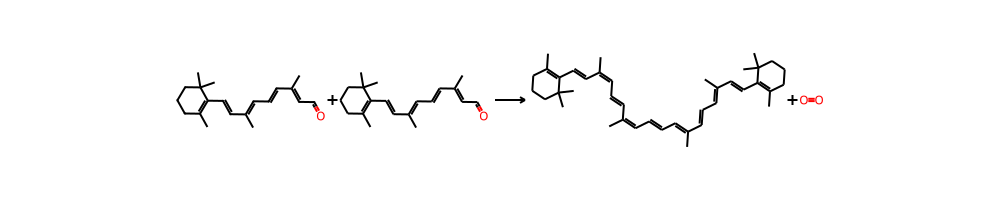

STEP #4
[('rid', 2585), ('rhea_ids', [32240]), ('imt_rules', None), ('weight', 1), ('requires', {}), ('other_products', {})]


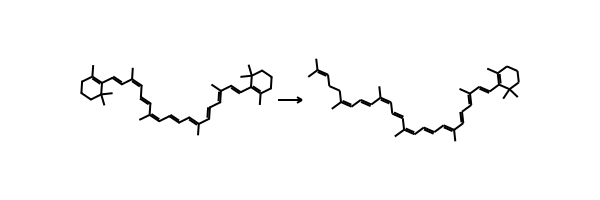

STEP #5
[('rid', 3273), ('rhea_ids', [32220]), ('imt_rules', None), ('weight', 1), ('requires', {}), ('other_products', {})]


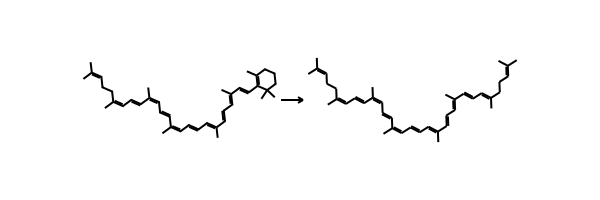

STEP #6
[('rid', 13177), ('rhea_ids', [58189]), ('imt_rules', None), ('weight', 1), ('requires', {'CC(C)=CCOP(=O)(O)OP(=O)(O)O': 1, 'O': 1}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 1})]


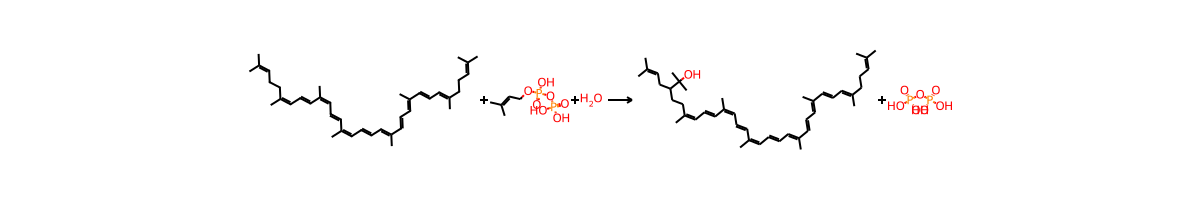

STEP #7
[('rid', 13177), ('rhea_ids', [58189]), ('imt_rules', None), ('weight', 1), ('requires', {'O=P(O)(O)OP(=O)(O)O': 1}), ('other_products', {'CC(C)=CCCC(C)=CC=CC(C)=CC=CC(C)=CC=CC=C(C)C=CC=C(C)C=CC=C(C)CCC=C(C)C': 1, 'O': 1})]


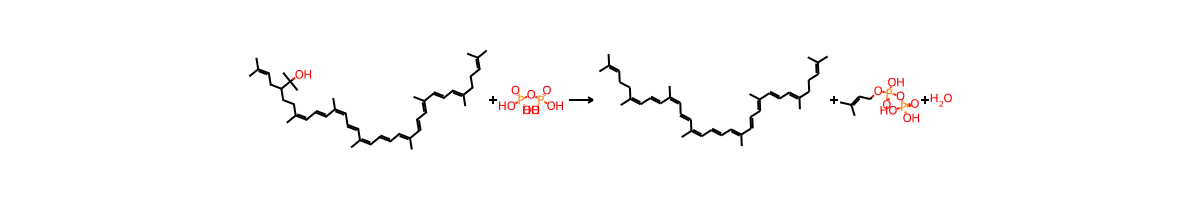

STEP #8
[('rid', 749), ('rhea_ids', [23286]), ('imt_rules', ['rule0028_17', 'rule0040_7']), ('weight', 1.0), ('requires', {}), ('other_products', {})]


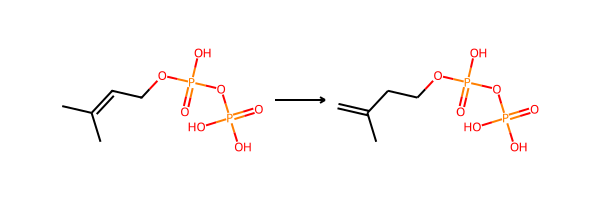

STEP #9
[('rid', 5353), ('rhea_ids', [27811]), ('imt_rules', None), ('weight', 1), ('requires', {'CC(C)=CCOP(=O)(O)OP(=O)(O)O': 1}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 2})]


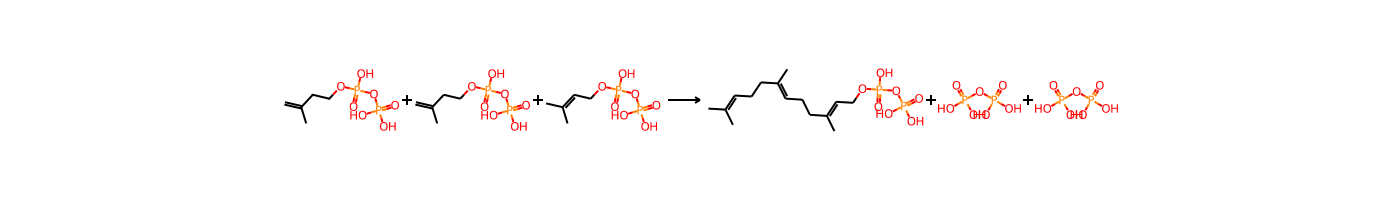

STEP #10
[('rid', 6931), ('rhea_ids', [73984]), ('imt_rules', None), ('weight', 1), ('requires', {}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 1})]


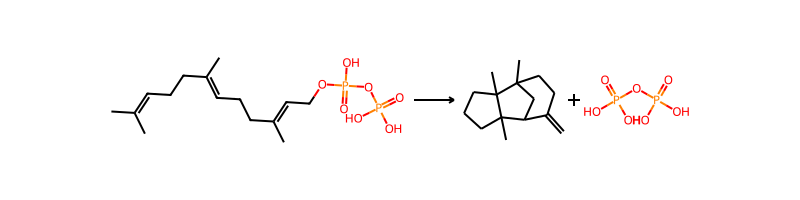

OVERALL:  a ganglioside GD3 >> abieta-7,13-diene


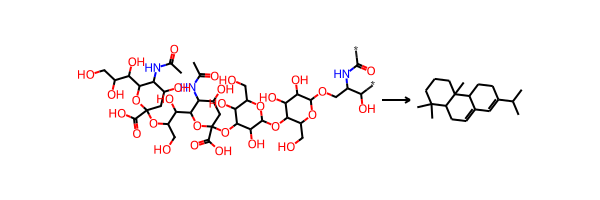

STEP #1
[('rid', 7601), ('rhea_ids', [48122]), ('imt_rules', None), ('weight', 1), ('requires', {'O': 1}), ('other_products', {'CC(=O)NC1C(O)CC(O)(C(=O)O)OC1C(O)C(O)CO': 1})]


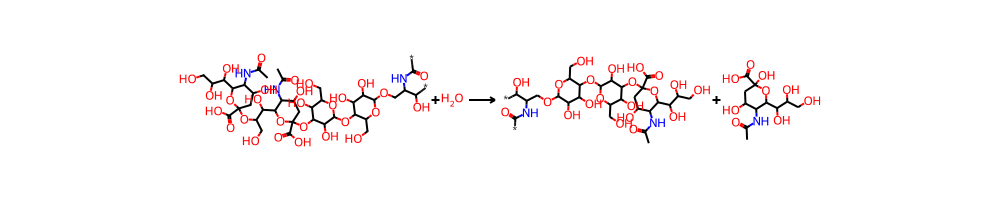

STEP #2
[('rid', 7274), ('rhea_ids', [65542]), ('imt_rules', ['rule0006_058', 'rule0006_085']), ('weight', 0.9), ('requires', {'O': 1}), ('other_products', {'CC(=O)NC1C(O)CC(OC2C(O)C(CO)OC(OC3C(CO)OC(O)C(O)C3O)C2O)(C(=O)O)OC1C(O)C(O)CO': 1})]


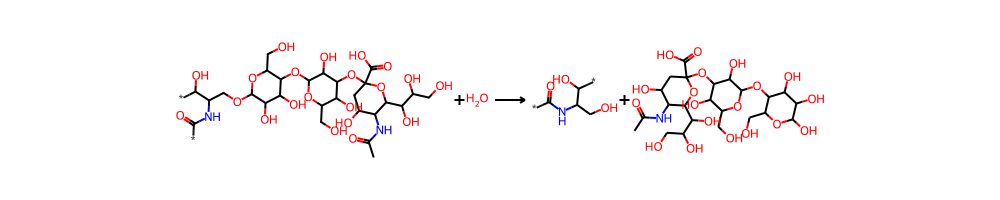

STEP #3
[('rid', 5696), ('rhea_ids', [61482, 61494]), ('imt_rules', ['rule0075_1']), ('weight', 0.058823529411764705), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'*C(O)C(N)CO': 1})]


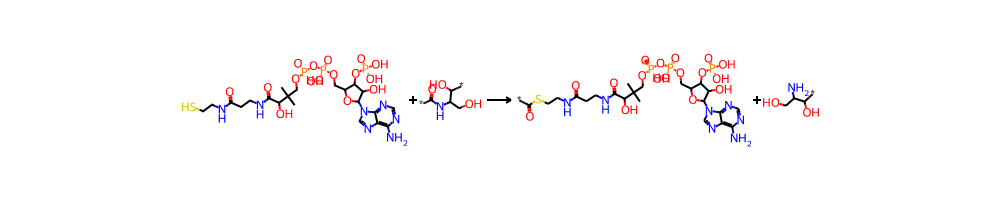

STEP #4
[('rid', 2380), ('rhea_ids', [50046]), ('imt_rules', ['rule0124_25']), ('weight', 1), ('requires', {'O': 1}), ('other_products', {'*C(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)O': 1})]


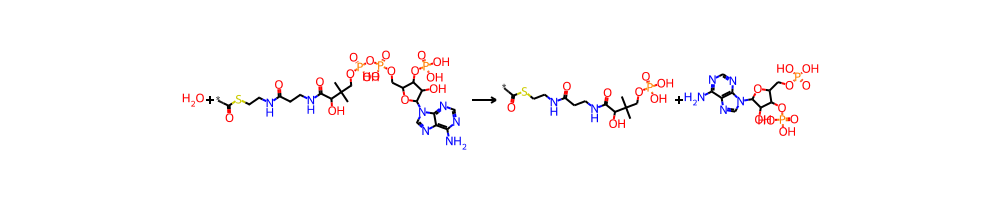

STEP #5
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


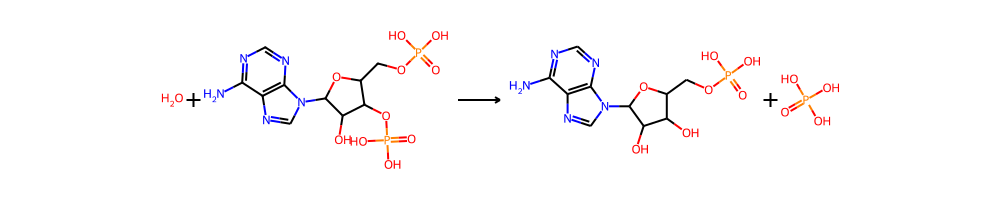

STEP #6
[('rid', 5930), ('rhea_ids', [15286]), ('imt_rules', ['rule0429_1']), ('weight', 0.8214285714285714), ('requires', {'CC(C)=CCOP(=O)(O)OP(=O)(O)O': 1}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 1})]


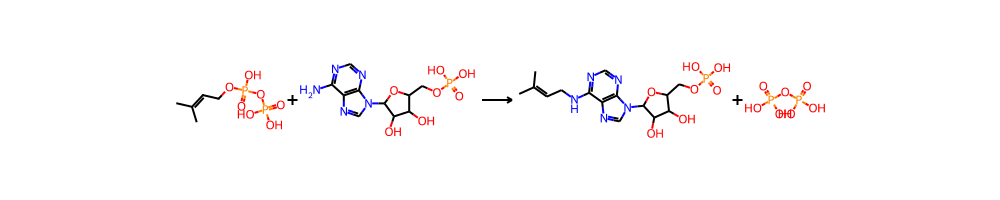

STEP #7
[('rid', 5930), ('rhea_ids', [15286]), ('imt_rules', ['rule0429_1']), ('weight', 0.35714285714285715), ('requires', {'O=P(O)(O)OP(=O)(O)O': 1}), ('other_products', {'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O': 1})]


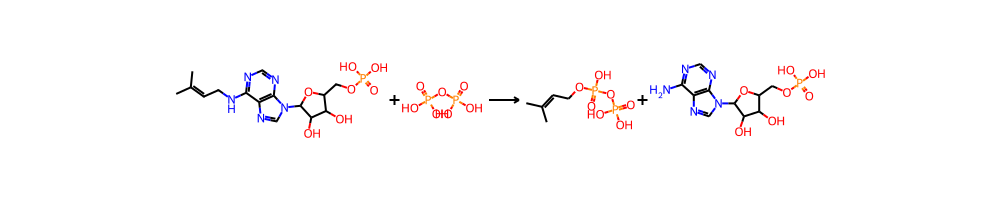

STEP #8
[('rid', 749), ('rhea_ids', [23286]), ('imt_rules', ['rule0028_17', 'rule0040_7']), ('weight', 1.0), ('requires', {}), ('other_products', {})]


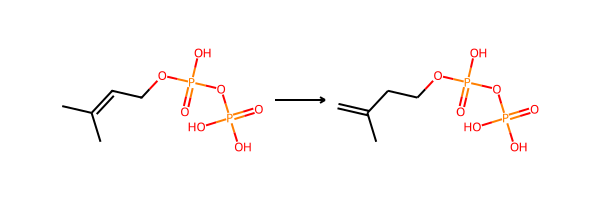

STEP #9
[('rid', 18780), ('rhea_ids', [55522]), ('imt_rules', None), ('weight', 1), ('requires', {'CC(C)=CCOP(=O)(O)OP(=O)(O)O': 1}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 3})]


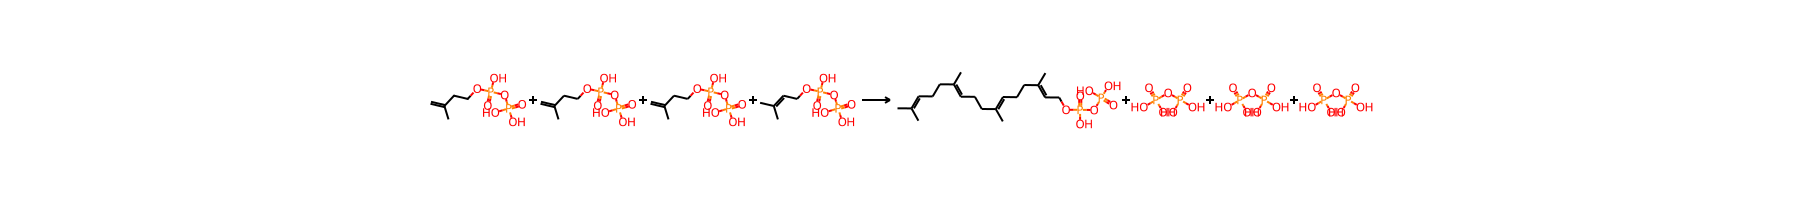

STEP #10
[('rid', 1231), ('rhea_ids', [14842, 25525, 24317]), ('imt_rules', None), ('weight', 1), ('requires', {}), ('other_products', {})]


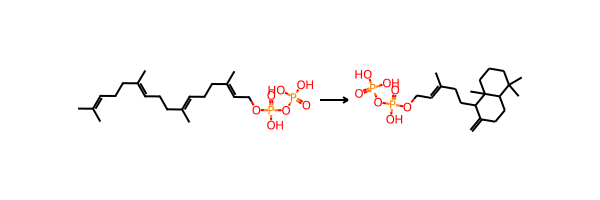

STEP #11
[('rid', 11419), ('rhea_ids', [13874]), ('imt_rules', None), ('weight', 1), ('requires', {}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 1})]


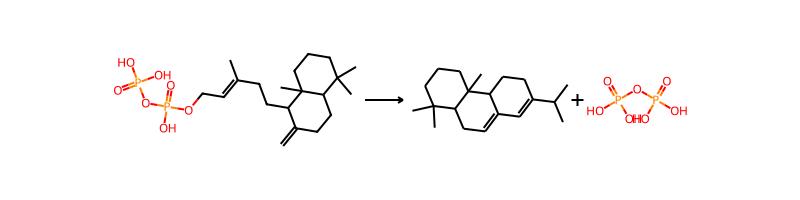

OVERALL:  a ganglioside GD3 >> N-acetylneuraminate


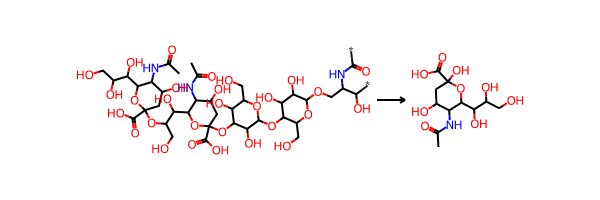

STEP #1
[('rid', 7601), ('rhea_ids', [48122]), ('imt_rules', None), ('weight', 1), ('requires', {'O': 1}), ('other_products', {'*C(=O)NC(COC1OC(CO)C(OC2OC(CO)C(O)C(OC3(C(=O)O)CC(O)C(NC(C)=O)C(C(O)C(O)CO)O3)C2O)C(O)C1O)C(*)O': 1})]


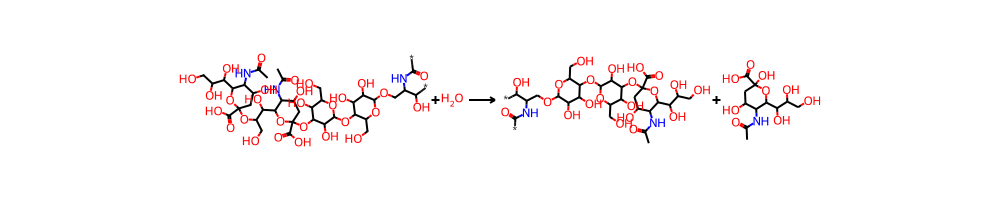

In [59]:
def show_path(source, target, topk = 1):
    overall = ">>".join((G.nodes[source]['smiles'], G.nodes[target]['smiles']))
    print("Overall: ".upper(), f"{G.nodes[source]['name']} >> {G.nodes[target]['name']}")
    display(SVG(draw_reaction(overall)))
    node_path, edge_path = G.shortest_path(source, target, rm_req_target=False)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items() if k != 'smarts'])
            display(SVG(draw_reaction(edge['smarts'])))

for pair in sts:
    show_path(*pair)

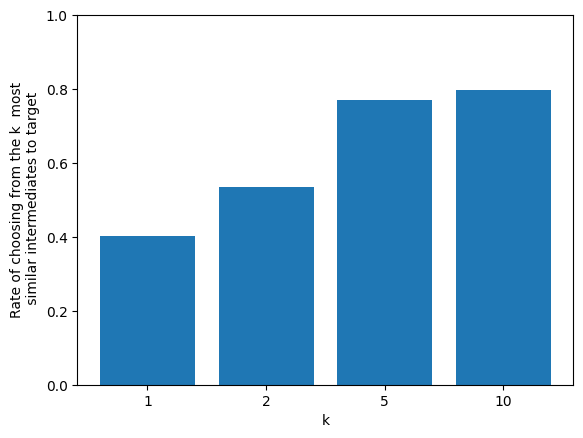

In [61]:
topks = [1, 2, 5, 10]
positive = [0 for _ in range(len(topks))]
n_steps = [0 for _ in range(len(topks))]
for x, k in enumerate(topks):
    for i in path_tanis_all_successors:
        for j in path_tanis_all_successors[i]:
            for step in range(1, len(path_tanis[i][j]) - 1):
                successors = path_tanis_all_successors[i][j][step - 1]
                if len(successors) > k:

                    chosen = path_tanis[i][j][step]
                    n_steps[x] += 1
                    srt_successors = sorted(successors, reverse=True)

                    if srt_successors.index(chosen) < k:
                        positive[x] += 1

fig, ax = plt.subplots()
ax.bar(list(range(len(topks))), [positive[i] / n_steps[i] for i in range(len(topks))], tick_label=topks)
ax.set_ylim(0, 1)
ax.set_xlabel("k")
ax.set_ylabel("Rate of choosing from the k  most\n similar intermediates to target")
plt.show()
